# Подготовка данных

Цель задания: определить уровень воды рек на постах гидрологического контроля, используя данные метеосводок и ежедневных наблюдений за 2008-2017 года.

### Проверка и установка рабочей директории, должен быть корень проекта

In [1]:
%pwd

'C:\\Users\\Kuroha\\source\\repos_py\\bauman_final_project\\notebooks'

In [2]:
%cd ..

C:\Users\Kuroha\source\repos_py\bauman_final_project


### Загрузка датасетов:

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import *

In [4]:
def open_dataset(dataset_name):
    path = get_filepath(dataset_name, is_raw=True)
    return pd.read_csv(path, index_col=['uid', 'date'], parse_dates=['date'], dtype={'uid': str})

weather_df = open_dataset(DATA_WEATHER)
water_lvl_df = open_dataset(DATA_WATER_LEVEL)

### Информация о датасетах:

#### water_level

В датасете представлены замеры уровня воды для постов гидрологического контроля с сайта АИС ГМВО.

In [5]:
water_lvl_df.head(3)

water_level
uid   date                   
09386 2008-01-01          138
      2008-01-02          138
      2008-01-03          138

In [6]:
water_lvl_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 98263 entries, ('09386', Timestamp('2008-01-01 00:00:00')) to ('09568', Timestamp('2017-12-31 00:00:00'))
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   water_level  98263 non-null  int64
dtypes: int64(1)
memory usage: 1.2+ MB


In [7]:
water_lvl_df.columns

Index(['water_level'], dtype='object')

In [8]:
water_lvl_df.shape

(98263, 1)

In [9]:
water_lvl_df.describe().T

,count,mean,std,min,25%,50%,75%,max
water_level,98263.0,261.419059,238.462117,0.0,108.0,214.0,314.0,2889.0


#### weather

В **weather** содержится погода на период 2008-2017 для обучения моделей, в котором есть следующие столбцы:
- индекс **uid** - идентификационный номер поста гидрологического контроля с сайта АИС ГМВО.
- индекс **date** - дата замера
- **temperature** - температура
- **cloud** - облачность
- **weather** - погодное явление

In [10]:
weather_df.head(3)

latitude  longitude  temperature cloud weather  \
uid   date                                                         
09386 2008-01-01  60.34528  102.28417          -15  dull   clear   
      2008-01-02  60.34528  102.28417          -26   sun   clear   
      2008-01-03  60.34528  102.28417          -41   sun   clear   

                  is_fallback_data  
uid   date                          
09386 2008-01-01                 1  
      2008-01-02                 1  
      2008-01-03                 1

In [11]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 75151 entries, ('09386', Timestamp('2008-01-01 00:00:00')) to ('09518', Timestamp('2017-12-31 00:00:00'))
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   latitude          75151 non-null  float64
 1   longitude         75151 non-null  float64
 2   temperature       75151 non-null  int64  
 3   cloud             74824 non-null  object 
 4   weather           75151 non-null  object 
 5   is_fallback_data  75151 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 3.8+ MB


In [12]:
weather_df.columns

Index(['latitude', 'longitude', 'temperature', 'cloud', 'weather',
       'is_fallback_data'],
      dtype='object')

In [13]:
weather_df.shape

(75151, 6)

In [14]:
weather_df.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,75151.0,61.422034,2.246286,57.86972,60.34528,61.01583,62.71389,65.79306
longitude,75151.0,99.002338,6.358906,87.96222,93.03500,100.21667,103.32778,108.42778
temperature,75151.0,-1.154622,18.572704,-54.00000,-15.00000,1.00000,14.00000,35.00000
is_fallback_data,75151.0,0.225306,0.417787,0.00000,0.00000,0.00000,0.00000,1.00000


***
### Сохранение статистических данных об уровне воды
Во время использования приложения для улучшения восприятия графиков необходимо показывать исторические данные об уровне воды, а именно минимальное, среднее и максимальное значение по каждому дню.

In [15]:
stats_water_df = water_lvl_df.reset_index()
stats_water_df['day_of_year'] = stats_water_df['date'].dt.dayofyear
#stats_water_df = stats_water_df.groupby(['uid', 'day_of_year']).agg({'water_level': (np.min, np.mean, np.max)})
stats_water_df = stats_water_df.groupby(['uid', 'day_of_year']).agg(min = ('water_level', 'min'),
                                                                    mean = ('water_level', 'mean'),
                                                                    max = ('water_level', 'max'))
stats_water_df.head()

min   mean  max
uid   day_of_year                 
09386 1            108  133.1  183
      2            108  133.1  183
      3            108  132.9  181
      4            108  132.9  181
      5            108  132.7  179

In [68]:
stats_water_df.to_csv(get_filepath(DATA_WATER_STATS, is_raw=True))

***
### Объединение тренировочных наборов данных:

In [17]:
df = weather_df.join(water_lvl_df)
df.head(), df.info(), df.shape, weather_df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 75151 entries, ('09386', Timestamp('2008-01-01 00:00:00')) to ('09518', Timestamp('2017-12-31 00:00:00'))
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   latitude          75151 non-null  float64
 1   longitude         75151 non-null  float64
 2   temperature       75151 non-null  int64  
 3   cloud             74824 non-null  object 
 4   weather           75151 non-null  object 
 5   is_fallback_data  75151 non-null  int64  
 6   water_level       71479 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 6.4+ MB


(                  latitude  longitude  temperature  cloud weather  \
 uid   date                                                          
 09386 2008-01-01  60.34528  102.28417          -15   dull   clear   
       2008-01-02  60.34528  102.28417          -26    sun   clear   
       2008-01-03  60.34528  102.28417          -41    sun   clear   
       2008-01-04  60.34528  102.28417          -39  suncl   clear   
       2008-01-05  60.34528  102.28417          -25   dull    snow   
 
                   is_fallback_data  water_level  
 uid   date                                       
 09386 2008-01-01                 1        138.0  
       2008-01-02                 1        138.0  
       2008-01-03                 1        138.0  
       2008-01-04                 1        138.0  
       2008-01-05                 1        138.0  ,
 None,
 (75151, 7),
 (75151, 6))

Количество строк до объединения **weather_df** и после осталось тем же.

### Работа с пропусками:

In [18]:
print(f'Размерность water_lvl_df: {water_lvl_df.shape}')
print(f'Размерность weather_df: {weather_df.shape}')
print(f'Размерность df: {df.shape}')

Размерность water_lvl_df: (98263, 1)
Размерность weather_df: (75151, 6)
Размерность df: (75151, 7)


В датасете **weather_df** есть строки за каждый день по каждому посту, однако в данных есть пропуски:

In [19]:
df[df.isnull().any(axis=1)]

latitude  longitude  temperature  cloud weather  \
uid   date                                                          
09386 2013-11-10  60.34528  102.28417           -3   dull   clear   
      2013-11-11  60.34528  102.28417           -5    sun   clear   
      2013-11-12  60.34528  102.28417           -5  suncl    snow   
      2013-11-13  60.34528  102.28417           -3   dull    snow   
      2013-11-14  60.34528  102.28417           -7  suncl    snow   
...                    ...        ...          ...    ...     ...   
09518 2016-07-27  59.24472  108.23250           25    NaN   clear   
      2016-09-18  59.24472  108.23250           15    NaN   clear   
      2016-09-20  59.24472  108.23250           10    NaN   clear   
      2016-09-28  59.24472  108.23250           11    NaN   clear   
      2017-08-14  59.24472  108.23250           28    NaN   clear   

                  is_fallback_data  water_level  
uid   date                                       
09386 2013-11-10                 1          NaN  
      2013-11-11                 1          NaN  
      2013-11-12                 1          NaN  
      2013-11-13                 1          NaN  
      2013-11-14                 1          NaN  
...                            ...          ...  
09518 2016-07-27                 0         93.0  
      2016-09-18                 0         79.0  
      2016-09-20                 0         79.0  
      2016-09-28                 0         79.0  
      2017-08-14                 0         63.0  

[3992 rows x 7 columns]

Рассмотрим данные с поста **9518** за период с **2016-09-17** по **2016-09-21**, где отсутствуют метео-данные:

In [20]:
test_start_date = '2016-09-17'
test_end_date   = '2016-09-21'
df.query('uid == 9518 and date >= @test_start_date and date <= @test_end_date')

,,latitude,longitude,temperature,cloud,weather,is_fallback_data,water_level
uid,date,,,,,,,


Посмотрим, в скольких строках отсутствуют данные:

In [21]:
df.isnull().sum()

latitude               0
longitude              0
temperature            0
cloud                327
weather                0
is_fallback_data       0
water_level         3672
dtype: int64

In [22]:
df.shape

(75151, 7)

In [23]:
print(f'Процент строк с отсутствующими данными об облачности: {df["cloud"].isnull().sum() / df.shape[0] * 100:.2f}%')
print(f'Процент строк с отсутствующими данными об уровне воды: {df["water_level"].isnull().sum() / df.shape[0] * 100:.2f}%')

Процент строк с отсутствующими данными об облачности: 0.44%
Процент строк с отсутствующими данными об уровне воды: 4.89%


Т.к. строк с частичными данными меньше 5%, то удалим их:

In [24]:
df = df.dropna()
df.shape

(71159, 7)

In [25]:
df.isnull().sum()

latitude            0
longitude           0
temperature         0
cloud               0
weather             0
is_fallback_data    0
water_level         0
dtype: int64

Чтобы в дальнейшем работать с текущими значениями внутри мультииндекса (uid и дата замера), создадим столбец с новым индексом:

In [26]:
df.reset_index(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71159 entries, 0 to 71158
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uid               71159 non-null  object        
 1   date              71159 non-null  datetime64[ns]
 2   latitude          71159 non-null  float64       
 3   longitude         71159 non-null  float64       
 4   temperature       71159 non-null  int64         
 5   cloud             71159 non-null  object        
 6   weather           71159 non-null  object        
 7   is_fallback_data  71159 non-null  int64         
 8   water_level       71159 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 4.9+ MB


### Обработка признаков:

#### Latitude (широта) и Longitude (долгота):

In [27]:
def print_col_info(column):
    print(f'''describe:
{column.describe(datetime_is_numeric=True)}
{"-" * 80}
unique:
{column.unique()}
{"-" * 80}
nunique:
{column.nunique()}
{"-" * 80}
value_count:
{column.value_counts()}''')

print_col_info(df['latitude'])

describe:
count    71159.000000
mean        61.373750
std          2.282041
min         57.869720
25%         60.345280
50%         60.723060
75%         62.713890
max         65.793060
Name: latitude, dtype: float64
--------------------------------------------------------------------------------
unique:
[60.34528  59.62583  60.72306  61.67778  62.31528  61.81528  61.739608
 61.326467 60.38028  61.01583  60.372237 61.61361  57.86972  58.24722
 59.24472  60.02472  61.28333  63.58917  64.28333  62.82083  65.79306
 58.26     59.31     62.71389 ]
--------------------------------------------------------------------------------
nunique:
24
--------------------------------------------------------------------------------
value_count:
60.380280    10127
65.793060     7191
64.283330     7134
57.869720     6181
60.345280     6169
62.713890     4325
61.677780     3629
58.260000     3628
61.283330     3586
60.723060     3554
61.015830     2909
62.315280     1053
60.024720     1032
59.244720     102

In [28]:
print_col_info(df['longitude'])

describe:
count    71159.000000
mean        98.963660
std          6.473101
min         87.962220
25%         93.035000
50%        100.216670
75%        103.954440
max        108.427780
Name: longitude, dtype: float64
--------------------------------------------------------------------------------
unique:
[102.28417  103.32778   97.51833   96.38333   92.11528   92.64222
 102.801881 100.482484  93.035     93.41583   92.625875  91.18222
 107.76694  108.42778  108.2325   108.08778  108.01667  103.95444
 100.21667   93.36528   87.96222  105.87333  106.34     101.11639 ]
--------------------------------------------------------------------------------
nunique:
24
--------------------------------------------------------------------------------
value_count:
93.035000     10127
87.962220      7191
100.216670     7134
107.766940     6181
102.284170     6169
101.116390     4325
96.383330      3629
105.873330     3628
108.016670     3586
97.518330      3554
93.415830      2909
92.115280      1053


Всего уникальных локаций - 24.

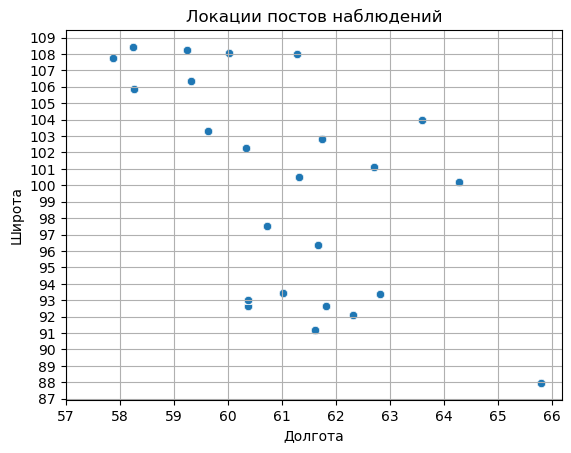

In [29]:
range_lat = range(int(df['latitude'].min()), int(df['latitude'].max() + 2))
range_long = range(int(df['longitude'].min()), int(df['longitude'].max() + 2))

ax = sns.scatterplot(data=df, x='latitude', y='longitude')
ax.set(xlabel='Долгота', ylabel='Широта', title='Локации постов наблюдений')
ax.set_xticks(range_lat)
ax.set_yticks(range_long)
plt.grid()
plt.show()

In [30]:
print(f"Разброс долготы: {df['longitude'].min()} {df['longitude'].max()}")
print(f"Разброс широты: {df['latitude'].min()} {df['latitude'].max()}")

Разброс долготы: 87.96222 108.42778
Разброс широты: 57.86972 65.79306


In [31]:
print('Ссылка на Яндекс.Карты с выделенным регионом: ' +
f"https://yandex.ru/maps/?ll={(df['longitude'].max() + df['longitude'].min()) / 2}," +
f"{(df['latitude'].max() + df['latitude'].min()) / 2}" +  # начальные координаты для показа, покажем центр
f"&rl={df['longitude'].min()},{df['latitude'].min()}" +  # координаты первой точки выделения
f"~{df['longitude'].max() - df['longitude'].min()},0" +  # вторая точка, в виде смещения относительно начальной
f"~0,{df['latitude'].max() - df['latitude'].min()}" +
f"~{df['longitude'].min() - df['longitude'].max()},0" +
f"~0,{df['latitude'].min() - df['latitude'].max()}" +
f"&z=5")  # приближение на карте

Ссылка на Яндекс.Карты с выделенным регионом: https://yandex.ru/maps/?ll=98.195,61.83139&rl=87.96222,57.86972~20.465559999999996,0~0,7.923339999999996~-20.465559999999996,0~0,-7.923339999999996&z=5


![Регион на Яндекс.Картах](images/yandex_map.png)

Данные признаки будут нормализованы.

#### Cloud (облачность):

In [32]:
print_col_info(df['cloud'])

describe:
count     71159
unique        4
top        dull
freq      27580
Name: cloud, dtype: object
--------------------------------------------------------------------------------
unique:
['dull' 'sun' 'suncl' 'sunc']
--------------------------------------------------------------------------------
nunique:
4
--------------------------------------------------------------------------------
value_count:
dull     27580
suncl    16177
sun      14327
sunc     13075
Name: cloud, dtype: int64


Облачность может быть следующей:
- **sun** - ясно
- **sunс** - малооблачно
- **suncl** - облачно
- **dull** - пасмурно

Здесь прослеживается порядок - от ясного неба к пасмурному, поэтому для кодирования данного упорядоченного признака необходимо использовать метод Label Encoder.

Реализация данного метода в sklearn перед кодированием [сортирует уникальные признаки в алфавитном порядке](https://github.com/scikit-learn/scikit-learn/blob/f3f51f9b611bf873bd5836748647221480071a87/sklearn/preprocessing/_label.py#L799), в результате чего будет нарушен порядок: **dull** будет закодирован как 0, **sun** - как 1, **sunс** - 2, **suncl** - 3.

In [33]:
df['cloud'] = df['cloud'].map({'sun': 0, 'sunc': 1, 'suncl': 2, 'dull': 3})
df.head(5)

,uid,date,latitude,longitude,temperature,cloud,weather,is_fallback_data,water_level
0,09386,2008-01-01,60.34528,102.28417,-15,3,clear,1,138.0
1,09386,2008-01-02,60.34528,102.28417,-26,0,clear,1,138.0
2,09386,2008-01-03,60.34528,102.28417,-41,0,clear,1,138.0
3,09386,2008-01-04,60.34528,102.28417,-39,2,clear,1,138.0
4,09386,2008-01-05,60.34528,102.28417,-25,3,snow,1,138.0


#### uid:

In [34]:
print_col_info(df['uid'])

describe:
count     71159
unique       28
top       09389
freq       3629
Name: uid, dtype: object
--------------------------------------------------------------------------------
unique:
['09386' '09387' '09388' '09389' '09390' '09392' '09393' '09396' '09397'
 '09499' '09523' '09560' '09568' '09403' '09404' '09405' '09406' '09408'
 '09410' '09413' '09415' '09416' '09417' '09419' '09420' '09421' '09422'
 '09518']
--------------------------------------------------------------------------------
nunique:
28
--------------------------------------------------------------------------------
value_count:
09389    3629
09416    3628
09568    3622
09415    3621
09403    3604
09397    3602
09406    3586
09387    3585
09420    3582
09410    3582
09404    3581
09422    3570
09386    3564
09388    3554
09419    3552
09396    3532
09560    3258
09405    1046
09417    1024
09518    1010
09392     990
09393     982
09523     980
09499     979
09408     978
09390     963
09413     812
09421     743
Name

Представляет собой идентификационный номер поста гидрологического контроля в базе данных сайта АИС ГМВО.

Задачу прогнозирования можно решить двумя способами:
1. Разработать одну модель для всех постов. Это имеет смысл, т.к. посты географически расположены близко друг к другу, а также замеряют уровень воды одной реки.
2. Разработать индивидуальные модели для всех постов.
    
Будет реализован первый вариант, т.к. недостаточно данных наблюдений по каждому посту. UID постов будут закодированы как категориальные данные, используя One Hot Encoding, однако предварительно нужно посмотреть, были ли случаи использования метео-данных по запасной локации - если их не было, то данные UIDы кодировать не нужно, т.к. их однозначно можно определить по координатам:

In [35]:
ignore_uids = df.groupby('uid').filter(lambda x: (x.is_fallback_data == 0).all())['uid'].unique()
ignore_uids

array(['09387', '09388', '09389', '09499', '09403', '09406', '09410',
       '09415', '09416', '09419', '09420', '09421', '09422'], dtype=object)

In [36]:
replace_map = dict(zip(ignore_uids, (None for x in range(len(ignore_uids)))))
replace_map

{'09387': None,
 '09388': None,
 '09389': None,
 '09499': None,
 '09403': None,
 '09406': None,
 '09410': None,
 '09415': None,
 '09416': None,
 '09419': None,
 '09420': None,
 '09421': None,
 '09422': None}

In [37]:
df['uid_copy'] = df['uid']  # копия uid для визуализации, будет удалена перед сохранением датасета
df['uid_copy'] = df['uid_copy'].replace(replace_map)
print_col_info(df['uid_copy'])

describe:
count     29944
unique       15
top       09568
freq       3622
Name: uid_copy, dtype: object
--------------------------------------------------------------------------------
unique:
['09386' None '09390' '09392' '09393' '09396' '09397' '09523' '09560'
 '09568' '09404' '09405' '09408' '09413' '09417' '09518']
--------------------------------------------------------------------------------
nunique:
15
--------------------------------------------------------------------------------
value_count:
09568    3622
09397    3602
09404    3581
09386    3564
09396    3532
09560    3258
09405    1046
09417    1024
09518    1010
09392     990
09393     982
09523     980
09408     978
09390     963
09413     812
Name: uid_copy, dtype: int64


In [38]:
def encode_uid(df_target):
    encoder = OneHotEncoder()
    df_uid = pd.DataFrame(encoder.fit_transform(df[['uid_copy']]).toarray())
    df_uid = df_uid.add_prefix('uid_')  # префикс для визуального определения признака
    df_uid = df_uid.astype('category')  # конвертация в категориальный тип данных
    return df_target.join(df_uid)

df = encode_uid(df)
df.head(2)

,uid,date,latitude,longitude,temperature,cloud,weather,is_fallback_data,water_level,uid_copy,...,uid_6,uid_7,uid_8,uid_9,uid_10,uid_11,uid_12,uid_13,uid_14,uid_15
0,09386,2008-01-01,60.34528,102.28417,-15,3,clear,1,138.0,09386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,09386,2008-01-02,60.34528,102.28417,-26,0,clear,1,138.0,09386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71159 entries, 0 to 71158
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uid               71159 non-null  object        
 1   date              71159 non-null  datetime64[ns]
 2   latitude          71159 non-null  float64       
 3   longitude         71159 non-null  float64       
 4   temperature       71159 non-null  int64         
 5   cloud             71159 non-null  int64         
 6   weather           71159 non-null  object        
 7   is_fallback_data  71159 non-null  int64         
 8   water_level       71159 non-null  float64       
 9   uid_copy          29944 non-null  object        
 10  uid_0             71159 non-null  category      
 11  uid_1             71159 non-null  category      
 12  uid_2             71159 non-null  category      
 13  uid_3             71159 non-null  category      
 14  uid_4             7115

In [40]:
df.query('uid_copy.isnull()').head(1).T

,3564
uid,09387
date,2008-01-01 00:00:00
latitude,60.34528
longitude,102.28417
temperature,-15
cloud,3
weather,clear
is_fallback_data,0
water_level,79.0
uid_copy,None


None закодировался в uid_15, удалим столбцы uid_copy и uid_15:

In [41]:
df = df.drop(['uid_copy', 'uid_15'], axis=1)
df.head(1).T

,0
uid,09386
date,2008-01-01 00:00:00
latitude,60.34528
longitude,102.28417
temperature,-15
cloud,3
weather,clear
is_fallback_data,1
water_level,138.0
uid_0,1.0


#### Date (дата):

In [42]:
print_col_info(df['date'])

describe:
count                            71159
mean     2013-06-13 20:09:59.603704576
min                2008-01-01 00:00:00
25%                2010-10-24 00:00:00
50%                2013-09-21 00:00:00
75%                2016-02-27 00:00:00
max                2017-12-31 00:00:00
Name: date, dtype: object
--------------------------------------------------------------------------------
unique:
['2008-01-01T00:00:00.000000000' '2008-01-02T00:00:00.000000000'
 '2008-01-03T00:00:00.000000000' ... '2015-10-07T00:00:00.000000000'
 '2015-11-15T00:00:00.000000000' '2015-11-18T00:00:00.000000000']
--------------------------------------------------------------------------------
nunique:
3648
--------------------------------------------------------------------------------
value_count:
2017-05-19    28
2016-06-01    28
2015-06-06    28
2015-06-07    28
2015-06-08    28
              ..
2015-09-21     6
2015-09-19     6
2015-09-18     6
2015-09-17     6
2015-11-18     4
Name: date, Length: 3648, 

Представляет собой день наблюдений. Данное значение можно закодировать как:
1. Год - категориальный признак, используя метод Label Encoder (есть порядок: 2008 год был раньше, чем 2017)
2. Номер дня в году - цикличный признак.

Значения дня представляет собой следующий график:

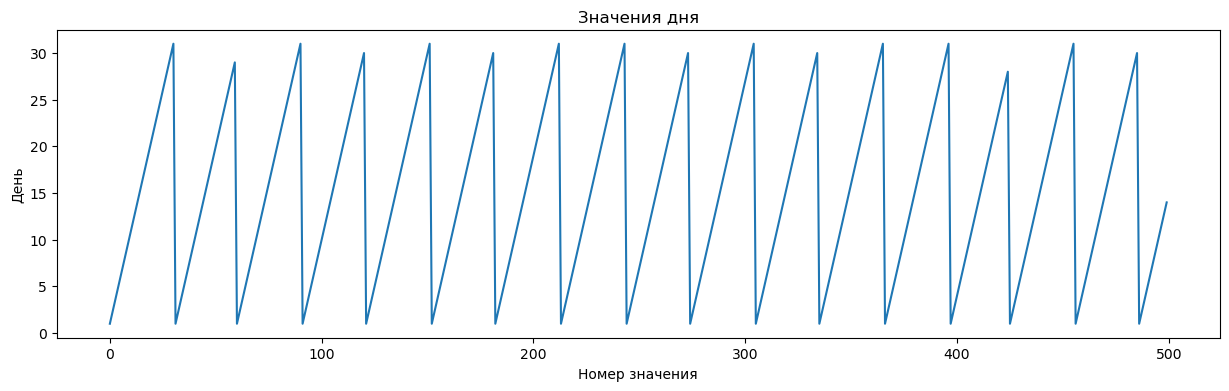

In [43]:
plt.figure(figsize=(15, 4))
plt.plot(df['date'].dt.day[:500])
plt.xlabel('Номер значения')
plt.ylabel('День')
plt.title('Значения дня')

plt.show()

Данные являются зацикленными, т.к. 31 день в месяце отличается от следующего 1-го дня лишь на одну единицу, а не на 30. Значение дня в году [можно представить в виде двух функций](http://blog.davidkaleko.com/feature-engineering-cyclical-features.html):

$x_{sin} = \sin(\frac{2 * \pi * x}{\max(x)})$

$x_{cos} = \cos(\frac{2 * \pi * x}{\max(x)})$

In [44]:
test_day = 70
np.sin(2 * np.pi * test_day/365.0), np.cos(2 * np.pi * test_day/365.0)

(0.9338372288229252, 0.35769823883312546)

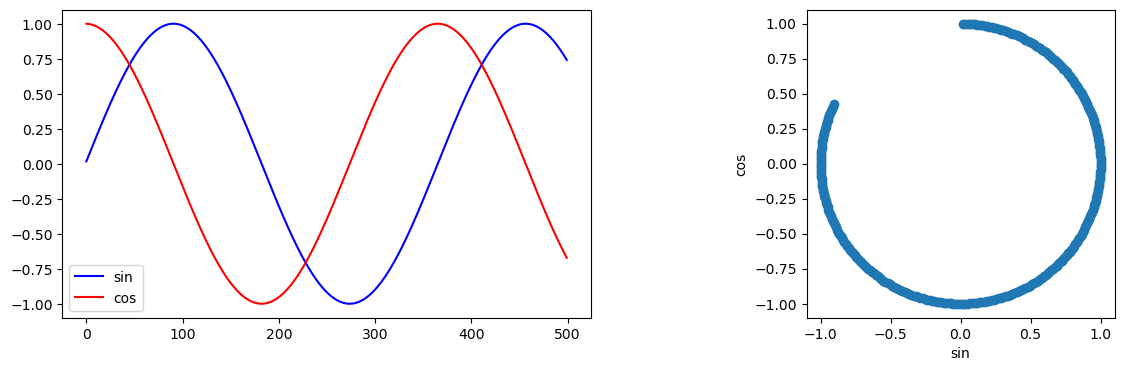

In [45]:
test_df = df[0:500]['date']
total_years = np.where(test_df.dt.is_leap_year, 366, 365)
test_arr = test_df.dt.dayofyear
test_sin = np.sin(2 * np.pi * test_arr / total_years)
test_cos = np.cos(2 * np.pi * test_arr / total_years)

fig = plt.figure(figsize=(15, 4))

ax1 = fig.add_subplot(121)
ax1.plot(test_sin, color='blue', label='sin')
ax1.plot(test_cos, color='red', label='cos')
ax1.legend()


# показ точек на графике за 300 дней

ax2 = fig.add_subplot(122)
ax2.set_aspect('equal')
ax2.scatter(test_sin[:300], test_cos[:300])
ax2.set_xlabel('sin')
ax2.set_ylabel('cos')

plt.show()

Закодируем год и номер дня в году:

In [46]:
total_years = np.where(df['date'].dt.is_leap_year, 366, 365)
df['year'] = df['date'].dt.year
df['day_sin'] = np.sin(2 * np.pi * df['date'].dt.dayofyear / total_years)
df['day_cos'] = np.cos(2 * np.pi * df['date'].dt.dayofyear / total_years)
df[['date', 'year', 'day_sin', 'day_cos']].head()

,date,year,day_sin,day_cos
0,2008-01-01,2008,0.017166,0.999853
1,2008-01-02,2008,0.034328,0.999411
2,2008-01-03,2008,0.051479,0.998674
3,2008-01-04,2008,0.068615,0.997643
4,2008-01-05,2008,0.085731,0.996318


In [47]:
df['year'].value_counts().sort_index()

2008    6403
2009    6230
2010    6317
2011    5899
2012    6242
2013    6148
2014    6259
2015    8382
2016    9655
2017    9624
Name: year, dtype: int64

#### Weather (осадки)

In [48]:
print_col_info(df['weather'])

describe:
count     71159
unique        4
top       clear
freq      54082
Name: weather, dtype: object
--------------------------------------------------------------------------------
unique:
['clear' 'snow' 'rain' 'storm']
--------------------------------------------------------------------------------
nunique:
4
--------------------------------------------------------------------------------
value_count:
clear    54082
snow     12790
rain      3704
storm      583
Name: weather, dtype: int64


Под осадками может пониматься следующее:
- **clear** - осадков не было
- **rain** - дождь
- **storm** - гроза
- **snow** - снег

Данный признак можно закодировать разными способами:
1. Выделение признака **наличие осадков**: и дождь, и снег образовываются из капель воды, а грозы, как правило, сопровождаются сильным дождём;
2. Объединение понятий "гроза" и "дождь", выделив 2 признака: **дождь** и **снег**;
3. 3 признака: **дождь**, **гроза**, **снег**, т.к. бывают сухие грозы;
4. В одном столбце будет указаны все осадки.

Во всех случаях отсутствие осадков обозначается 0 во всех признаках.

In [49]:
df['weather_v1_precip'] = df['weather'].map({'clear': 0, 'rain': 1, 'storm': 1, 'snow': 1})

df['weather_v2_rain'] = df['weather'].map({'clear': 0, 'rain': 1, 'storm': 1, 'snow': 0})

# снег одинаково обозначается во 2 и 3 случаях
df['weather_snow'] = df['weather'].map({'clear': 0, 'rain': 0, 'storm': 0, 'snow': 1})

df['weather_v3_rain'] = df['weather'].map({'clear': 0, 'rain': 1, 'storm': 0, 'snow': 0})
df['weather_v3_storm'] = df['weather'].map({'clear': 0, 'rain': 0, 'storm': 1, 'snow': 0})

df['weather_v4'] = df['weather'].map({'clear': 0, 'rain': 1, 'storm': 2, 'snow': 3})

df = df.drop(['weather'], axis=1)

In [50]:
df.head().T

,0,1,2,3,4
uid,09386,09386,09386,09386,09386
date,2008-01-01 00:00:00,2008-01-02 00:00:00,2008-01-03 00:00:00,2008-01-04 00:00:00,2008-01-05 00:00:00
latitude,60.34528,60.34528,60.34528,60.34528,60.34528
longitude,102.28417,102.28417,102.28417,102.28417,102.28417
temperature,-15,-26,-41,-39,-25
cloud,3,0,0,2,3
is_fallback_data,1,1,1,1,1
water_level,138.0,138.0,138.0,138.0,138.0
uid_0,1.0,1.0,1.0,1.0,1.0
uid_1,0.0,0.0,0.0,0.0,0.0


### Визуализация статистики:

Динамика изменения уровня воды на примере 6 постов наблюдений:

C:\Users\Kuroha\AppData\Local\Temp\ipykernel_14828\1805620954.py:4: UserWarning: The palette list has more values (28) than needed (18), which may not be intended.
  sns.relplot(data=test_df, x='date', y='water_level', palette=palette,


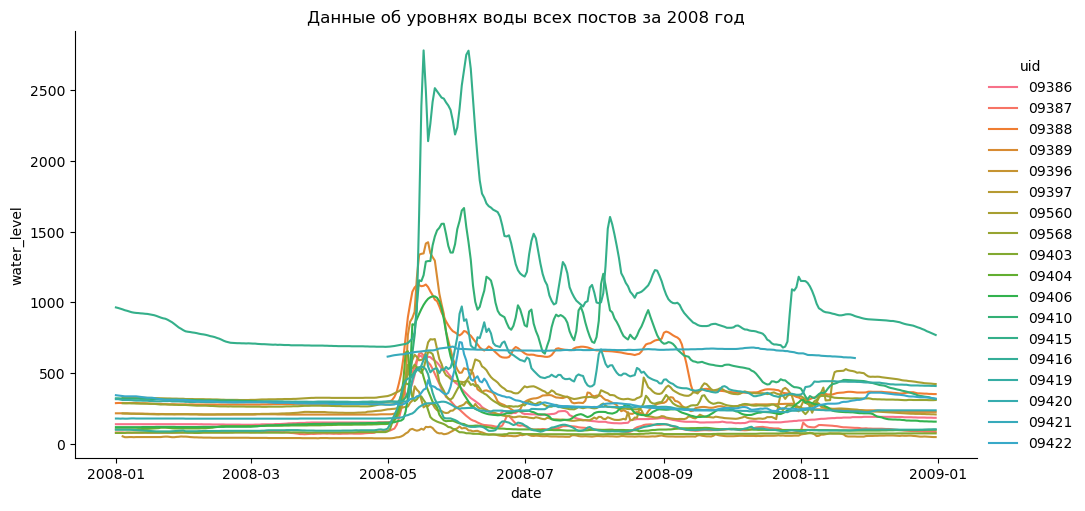

In [51]:
test_df = df[df['date'].dt.year == START_YEAR]

palette = sns.color_palette("husl", 28)
sns.relplot(data=test_df, x='date', y='water_level', palette=palette,
            hue='uid', kind="line", aspect=2, legend='full').set(
                title=f'Данные об уровнях воды всех постов за {START_YEAR} год')

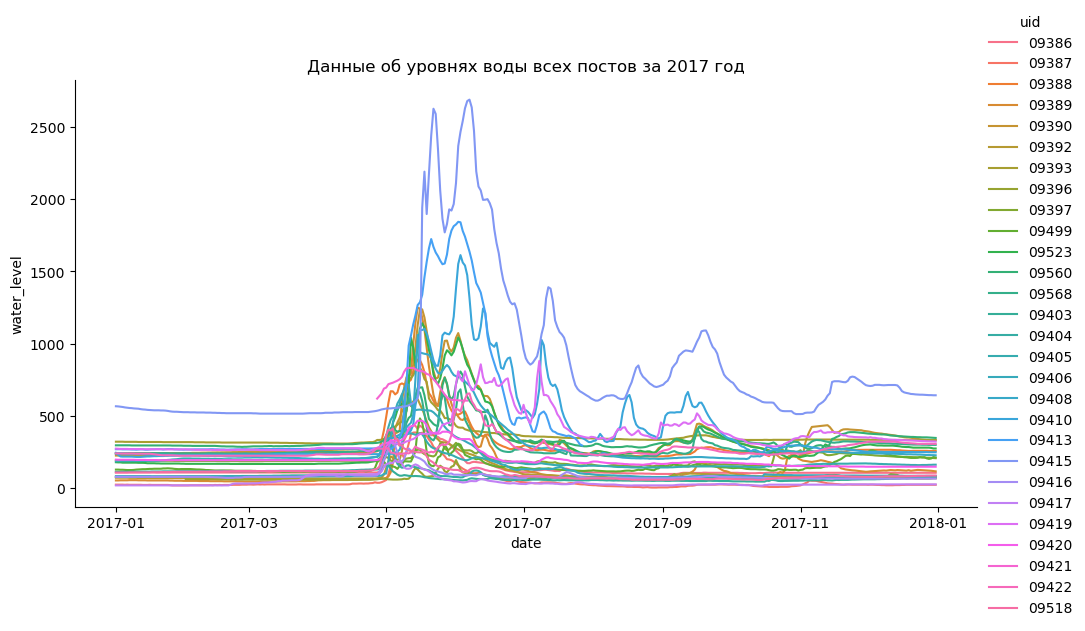

In [52]:
test_df = df[df['date'].dt.year == END_YEAR]

palette = sns.color_palette("husl", 28)
sns.relplot(data=test_df, x='date', y='water_level', palette=palette,
            hue='uid', kind="line", aspect=2, legend='full').set(
                title=f'Данные об уровнях воды всех постов за {END_YEAR} год')

Не для всех постов есть данные за каждый день, например:

In [53]:
test_start_date = '2008-01-01'
test_end_date = '2008-12-31'

test_df = df.query('uid == 9421 and date >= @START_YEAR and date <= @test_end_date')
test_df['date'].head(3), test_df['date'].tail(3)

(Series([], Name: date, dtype: datetime64[ns]),
 Series([], Name: date, dtype: datetime64[ns]))

В 2008 году у поста 9421 (руч.без названия - факт.Кербо) есть показания от 1 мая до 25 ноября.

### Работа с аномалиями данных

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71159 entries, 0 to 71158
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   uid                71159 non-null  object        
 1   date               71159 non-null  datetime64[ns]
 2   latitude           71159 non-null  float64       
 3   longitude          71159 non-null  float64       
 4   temperature        71159 non-null  int64         
 5   cloud              71159 non-null  int64         
 6   is_fallback_data   71159 non-null  int64         
 7   water_level        71159 non-null  float64       
 8   uid_0              71159 non-null  category      
 9   uid_1              71159 non-null  category      
 10  uid_2              71159 non-null  category      
 11  uid_3              71159 non-null  category      
 12  uid_4              71159 non-null  category      
 13  uid_5              71159 non-null  category      
 14  uid_6 

Рассмотрим зависимости признаков:

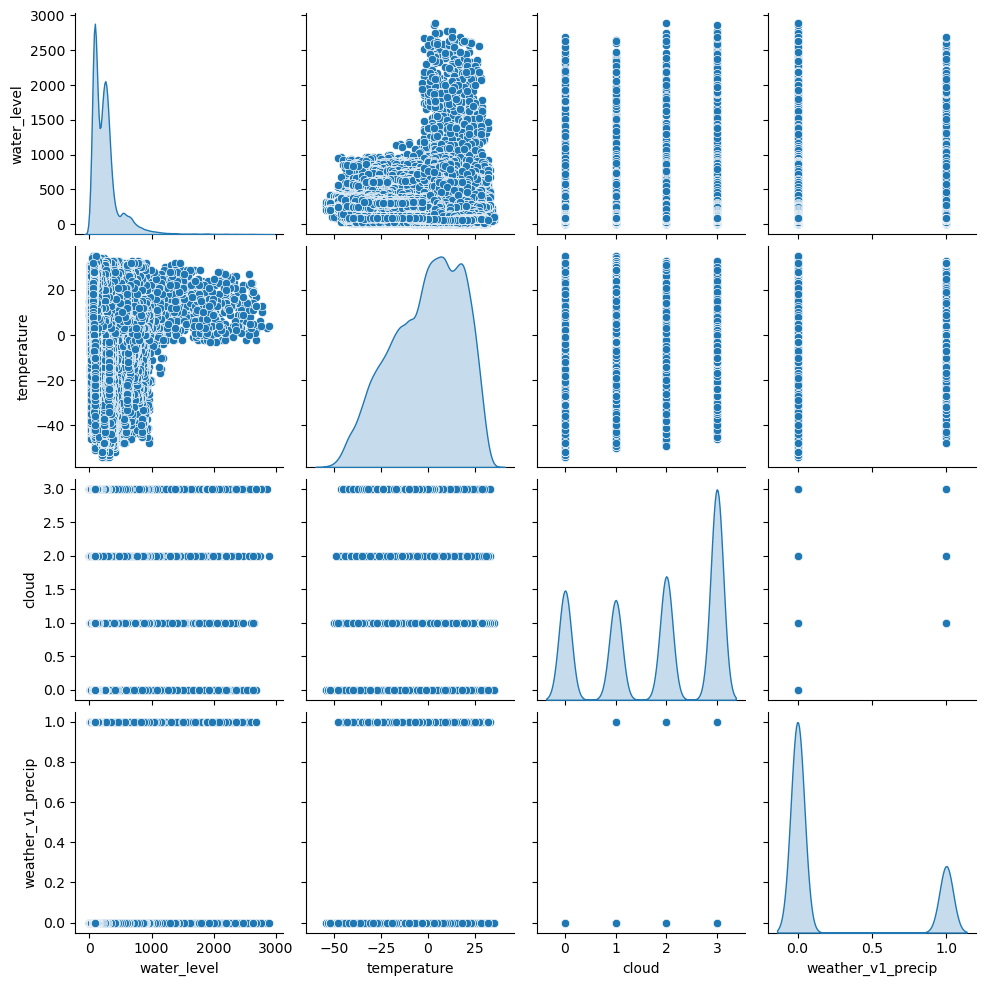

In [55]:
sns.pairplot(df[['water_level', 'temperature', 'cloud', 'weather_v1_precip']], diag_kind='kde')

По графикам видно, что уровень воды снижается при температуре ниже 0 градуса.

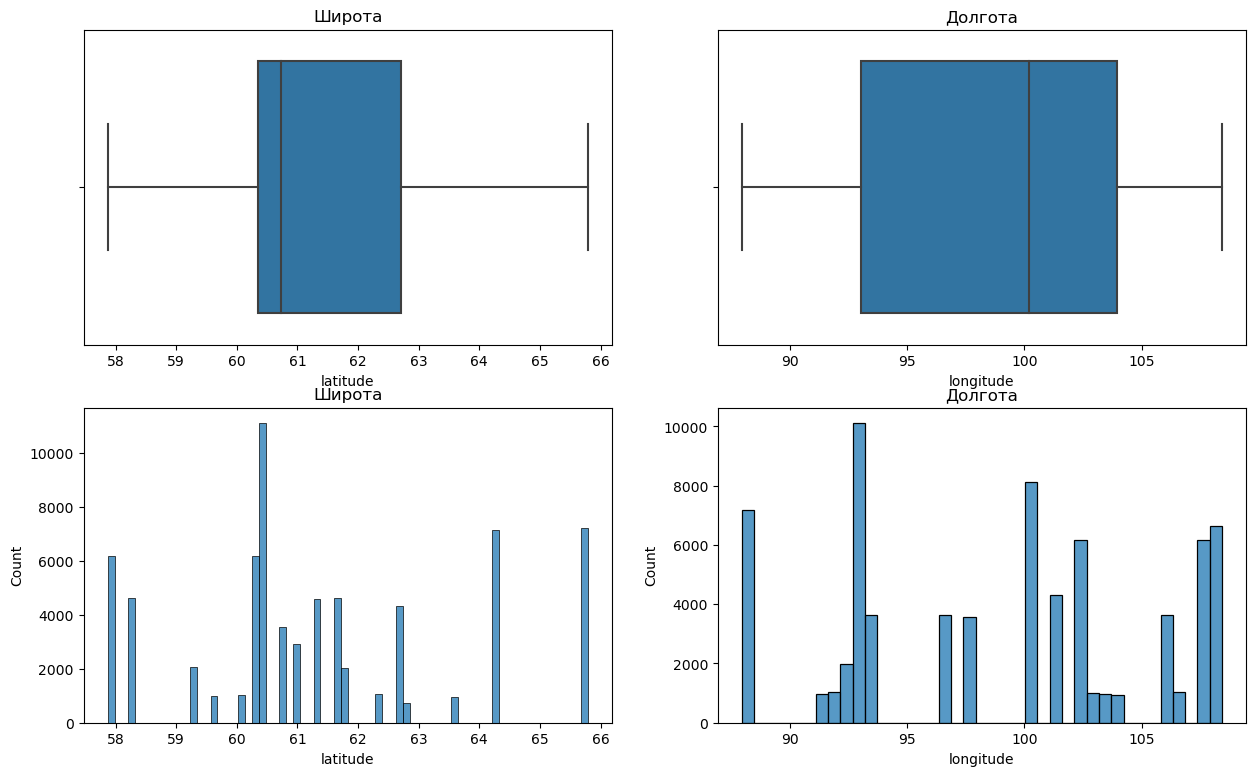

In [56]:
fig = plt.figure(figsize=(15, 9))

ax1 = fig.add_subplot(221)
sns.boxplot(data=df, x='latitude', ax=ax1).set(title='Широта')

ax2 = fig.add_subplot(222)
sns.boxplot(data=df, x='longitude', ax=ax2).set(title='Долгота')

ax3 = fig.add_subplot(223)
sns.histplot(data=df, x='latitude', ax=ax3).set(title='Широта')

ax4 = fig.add_subplot(224)
sns.histplot(data=df, x='longitude', ax=ax4).set(title='Долгота')

plt.show()

Широта и долгота не имеет выбросов.

[Text(0.5, 0, 'latitude'),
 Text(1.5, 0, 'longitude'),
 Text(2.5, 0, 'temperature'),
 Text(3.5, 0, 'cloud'),
 Text(4.5, 0, 'is_fallback_data'),
 Text(5.5, 0, 'water_level'),
 Text(6.5, 0, 'year'),
 Text(7.5, 0, 'day_sin'),
 Text(8.5, 0, 'day_cos'),
 Text(9.5, 0, 'weather_v1_precip'),
 Text(10.5, 0, 'weather_v2_rain'),
 Text(11.5, 0, 'weather_snow'),
 Text(12.5, 0, 'weather_v3_rain'),
 Text(13.5, 0, 'weather_v3_storm'),
 Text(14.5, 0, 'weather_v4')]

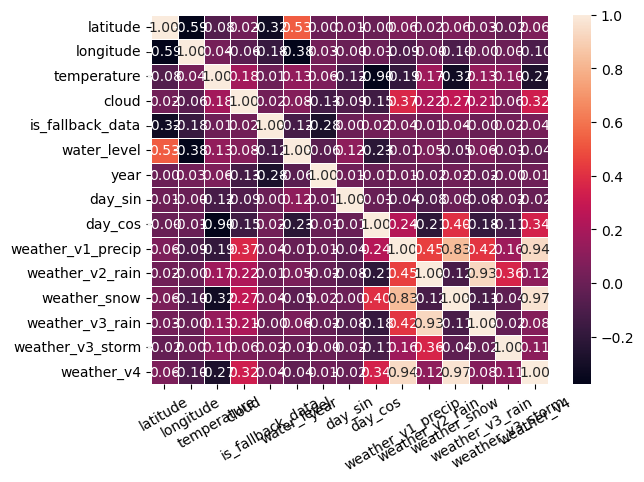

In [57]:
heatmap = sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt=".2f", robust=True)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation = 30)

Температура значительно отрицательно коррелирует с day_cos.

## Нормализация данных

In [58]:
df.select_dtypes(include=[np.number]).head(1)

,latitude,longitude,temperature,cloud,is_fallback_data,water_level,year,day_sin,day_cos,weather_v1_precip,weather_v2_rain,weather_snow,weather_v3_rain,weather_v3_storm,weather_v4
0,60.34528,102.28417,-15,3,1,138.0,2008,0.017166,0.999853,0,0,0,0,0,0


In [59]:
df['cloud'].value_counts()

3    27580
2    16177
0    14327
1    13075
Name: cloud, dtype: int64

Перед обучением модели необходимо привести нормализацию данных, а именно **temperature** и **year** (последний нужно закодировать с запасом на будущее).

In [60]:
orig_first_year = df.at[0, 'year']
orig_first_year

2008

Изменяем год в первом записи для того, чтобы нормализация по году прошла с учётом будущих годов:

In [61]:
df['year'].head(2)

0    2008
1    2008
Name: year, dtype: int64

In [62]:
df.at[0, 'year'] = 2030
df.at[0, 'year']

2030

Перед нормализацией данных необходимо сохранить минимальные и максимальные значения:

In [63]:
uid_min = df['uid'].min()
uid_max = df['uid'].max()
temperature_min = df['temperature'].min()
temperature_max = df['temperature'].max()
latitude_min = df['latitude'].min()
latitude_max = df['latitude'].max()
longitude_min = df['longitude'].min()
longitude_max = df['longitude'].max()

In [64]:
from sklearn.preprocessing import minmax_scale

columns_to_scale = ['temperature', 'cloud', 'year', 'latitude', 'longitude', 'uid']

df[columns_to_scale] = minmax_scale(df[columns_to_scale])
df[columns_to_scale]

,temperature,cloud,year,latitude,longitude,uid
0,0.438202,1.000000,1.000000,0.312439,0.699807,0.000000
1,0.314607,0.000000,0.000000,0.312439,0.699807,0.000000
2,0.146067,0.000000,0.000000,0.312439,0.699807,0.000000
3,0.168539,0.666667,0.000000,0.312439,0.699807,0.000000
4,0.325843,1.000000,0.000000,0.312439,0.699807,0.000000
...,...,...,...,...,...,...
71154,0.415730,1.000000,0.409091,0.173538,0.990458,0.725275
71155,0.404494,0.000000,0.409091,0.173538,0.990458,0.725275
71156,0.359551,0.333333,0.409091,0.173538,0.990458,0.725275
71157,0.393258,0.333333,0.409091,0.173538,0.990458,0.725275


Возвращаем обратно год в первой записи:

In [65]:
df.at[0, 'year'] = df.at[1, 'year']
df.at[0, 'year']

0.0

## Сохранение данных

In [66]:
df.to_csv(get_filepath(DATA_PROCESSED_TRAIN, is_raw=False), index=False)

Также сохраним пороговые значения для давления и скорости ветра для дальнейшего их применения к целевым данным, по которым будут производиться предсказания в дальнейшем:

In [67]:
norm_info = [[uid_min, f"{START_YEAR}-01-01", latitude_min, longitude_min, temperature_min, 'still', 0],
             [uid_max, f"2030-01-01", latitude_max, longitude_max, temperature_max, 'still', 1]]
write_data(DATA_NORMALIZATION, data=norm_info, is_raw=True)